# $$\varpi \equiv \kappa\nabla^2 b = \kappa \Big[\frac{\partial b}{\partial \theta} (\nabla^2 \theta) + \frac{\partial b}{\partial s} (\nabla^2 s)\Big]$$

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39293")
client

<Client: 'tcp://127.0.0.1:39293' processes=8 threads=40, memory=168.99 GB>

In [32]:
client.restart()

<Client: 'tcp://127.0.0.1:34291' processes=0 threads=0, memory=0 B>

In [2]:
import numpy as np
import xarray as xr
# from dask.diagnostics import ProgressBar
import os.path as op
import xrft
import gsw
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
from fastjmd95 import drhods, drhodt
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA/'

In [4]:
grav = 9.81
nensembs = 23
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rho0 = 9.998e2
Cp = 3.994e3
ystart = -15
yend = 50
dnf = 2160
nfile = 73
xchunk = 250
ychunk = 250
mchunk = 3
t_of_interest = 1

In [5]:
for memb in range(36,60):
    if memb == 36:
        ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run1967/ocn/' % memb), 
                             grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                             prefix=['diag_ocnTave','diag_dissTS'], 
                             delta_t=2e2, iters=1421280,
                             chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                            )

    else:
        ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run1967/ocn/' % memb), 
                                            grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                            prefix=['diag_ocnTave','diag_dissTS'], 
                                            delta_t=2e2, iters=1421280,
                                            chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                           )
                       ], dim='nmemb')
        
ds.coords['nmemb'] = ('nmemb',range(24,48))
ds

<xarray.Dataset>
Dimensions:   (XC: 1000, XG: 1000, YC: 900, YG: 900, Z: 46, Zl: 46, Zp1: 47, Zu: 46, nmemb: 24, time: 1)
Coordinates: (12/34)
    iter      (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time      (time) timedelta64[ns] 3290 days
  * XC        (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC        (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG        (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG        (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
    ...        ...
    maskS     (Z, YG, XC) bool dask.array<chunksize=(46, 200, 200), meta=np.ndarray>
    maskInC   (YC, XC) bool dask.array<chunksize=(200, 200), meta=np.ndarray>
    rhoRef    (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskInW   (YC, XG) bool dask.array<chunksize=(200, 200), meta=np.ndarray>
    maskInS   (YG, XC) bool dask.array<chunksize=(200, 200), meta=np.ndarray>
  * nmemb     (nmemb) int64 24 25 26 27 28 29 30 31 ... 40 41 42 43 44 45 46 47
Data variables:
    THETA     (nmemb, time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 46, 200, 200), meta=np.ndarray>
    SALT      (nmemb, time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 46, 200, 200), meta=np.ndarray>
    UVEL      (nmemb, time, Z, YC, XG) float32 dask.array<chunksize=(1, 1, 46, 200, 200), meta=np.ndarray>
    VVEL      (nmemb, time, Z, YG, XC) float32 dask.array<chunksize=(1, 1, 46, 200, 200), meta=np.ndarray>
    WVEL      (nmemb, time, Zl, YC, XC) float32 dask.array<chunksize=(1, 1, 46, 200, 200), meta=np.ndarray>
    PHIHYD    (nmemb, time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 46, 200, 200), meta=np.ndarray>
    Diss_TH   (nmemb, time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 46, 200, 200), meta=np.ndarray>
    Diss_SLT  (nmemb, time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 46, 200, 200), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [7]:
grid = Grid(ds, periodic=['X'])
grid

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
X Axis (periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center

In [8]:
xA = ds.hFacW * ds.dyG * ds.drF
yA = ds.hFacS * ds.dxG * ds.drF
dxC_r = ds.dxC**-1
dyC_r = ds.dyC**-1
dxG_r = ds.dxG**-1
dyG_r = ds.dyG**-1
drF_r = ds.drF**-1
drC_r = ds.drC**-1
hFacC_r = ds.hFacC**-1
rA_r = ds.rA**-1
xA

<xarray.DataArray (Z: 46, YC: 900, XG: 1000)>
dask.array<mul, shape=(46, 900, 1000), dtype=float32, chunksize=(46, 200, 200), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * Z        (Z) >f4 -3.047 -9.454 -16.36 ... -5.375e+03 -5.625e+03 -5.875e+03
    dyG      (YC, XG) >f4 dask.array<chunksize=(200, 200), meta=np.ndarray>
    dxC      (YC, XG) >f4 dask.array<chunksize=(200, 200), meta=np.ndarray>
    rAw      (YC, XG) >f4 dask.array<chunksize=(200, 200), meta=np.ndarray>
    drF      (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefC   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    hFacW    (Z, YC, XG) >f4 dask.array<chunksize=(46, 200, 200), meta=np.ndarray>
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 200, 200), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(200, 200), meta=np.ndarray>

In [9]:
dTdx = xA*grid.diff(ds.THETA,'X') * dxC_r
dTdy = yA*grid.diff(ds.THETA,'Y',boundary='fill') * dyC_r
del2T = rA_r * drF_r * hFacC_r * (grid.diff(dTdx,'X') 
                                  + grid.diff(dTdy,'Y',boundary='fill'))

FxT_diff = -Kh*dTdx + K4*xA*dxC_r*grid.diff(del2T,'X')
FyT_diff = -Kh*dTdy + K4*yA*dyC_r*grid.diff(del2T,'Y',boundary='fill')
FrT_diff = -Kr*ds.rA * drC_r * -grid.diff(ds.THETA,'Z',boundary='fill',to='outer')
FxT_diff

<xarray.DataArray (Z: 46, YC: 900, XG: 1000, nmemb: 24, time: 1)>
dask.array<add, shape=(46, 900, 1000, 24, 1), dtype=float32, chunksize=(46, 198, 197, 1, 1), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * Z        (Z) >f4 -3.047 -9.454 -16.36 ... -5.375e+03 -5.625e+03 -5.875e+03
    dyG      (YC, XG) >f4 dask.array<chunksize=(200, 200), meta=np.ndarray>
    dxC      (YC, XG) >f4 dask.array<chunksize=(200, 200), meta=np.ndarray>
    rAw      (YC, XG) >f4 dask.array<chunksize=(200, 200), meta=np.ndarray>
    ...       ...
    hFacW    (Z, YC, XG) >f4 dask.array<chunksize=(46, 200, 200), meta=np.ndarray>
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 200, 200), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(200, 200), meta=np.ndarray>
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * time     (time) timedelta64[ns] 3290 days

In [10]:
dSdx = xA*grid.diff(ds.SALT,'X') * dxC_r
dSdy = yA*grid.diff(ds.SALT,'Y',boundary='fill') * dyC_r
del2S = rA_r * drF_r * hFacC_r * (grid.diff(dSdx,'X') 
                                  + grid.diff(dSdy,'Y',boundary='fill'))

FxS_diff = -Kh*dSdx + K4*xA*dxC_r*grid.diff(del2S,'X')    
FyS_diff = -Kh*dSdy + K4*yA*dyC_r*grid.diff(del2S,'Y',boundary='fill')
FrS_diff = -Kr*ds.rA * drC_r * -grid.diff(ds.SALT,'Z',boundary='fill',to='outer')
FyS_diff

<xarray.DataArray (Z: 46, YG: 900, XC: 1000, nmemb: 24, time: 1)>
dask.array<add, shape=(46, 900, 1000, 24, 1), dtype=float32, chunksize=(46, 197, 198, 1, 1), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
  * Z        (Z) >f4 -3.047 -9.454 -16.36 ... -5.375e+03 -5.625e+03 -5.875e+03
    dxG      (YG, XC) >f4 dask.array<chunksize=(200, 200), meta=np.ndarray>
    dyC      (YG, XC) >f4 dask.array<chunksize=(200, 200), meta=np.ndarray>
    rAs      (YG, XC) >f4 dask.array<chunksize=(200, 200), meta=np.ndarray>
    ...       ...
    hFacS    (Z, YG, XC) >f4 dask.array<chunksize=(46, 200, 200), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 200, 200), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(200, 200), meta=np.ndarray>
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * time     (time) timedelta64[ns] 3290 days

In [11]:
GT_diff = -(grid.diff(FxT_diff,'X').where(ds.maskInC!=0.) 
            + grid.diff(FyT_diff,'Y',boundary='fill').where(ds.maskInC!=0.)
            - grid.diff(FrT_diff,'Z',boundary='fill')
           ) * hFacC_r * drF_r * rA_r
GS_diff = -(grid.diff(FxS_diff,'X').where(ds.maskInC!=0.) 
            + grid.diff(FyS_diff,'Y',boundary='fill').where(ds.maskInC!=0.)
            - grid.diff(FrS_diff,'Z',boundary='fill')
           ) * hFacC_r * drF_r * rA_r
GT_diff

<xarray.DataArray (Z: 46, YC: 900, XC: 1000, nmemb: 24, time: 1)>
dask.array<mul, shape=(46, 900, 1000, 24, 1), dtype=float32, chunksize=(44, 196, 196, 1, 1), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * Z        (Z) >f4 -3.047 -9.454 -16.36 ... -5.375e+03 -5.625e+03 -5.875e+03
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * time     (time) timedelta64[ns] 3290 days
    rA       (YC, XC) >f4 dask.array<chunksize=(200, 200), meta=np.ndarray>
    ...       ...
    maskInC  (YC, XC) bool dask.array<chunksize=(200, 200), meta=np.ndarray>
    drF      (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefC   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    hFacC    (Z, YC, XC) >f4 dask.array<chunksize=(46, 200, 200), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(46, 200, 200), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>

In [25]:
DiffE = - (-grid.diff(dsocn.DFrE_TH,'Z',boundary='fill') * Vol_r
           + grid.diff(dsocn.DFxE_TH,'X') * Vol_r
           + grid.diff(dsocn.DFyE_TH,'Y',boundary='fill') * Vol_r
          ).where(dsocn.maskC!=0.)
DiffI = (grid.diff(dsocn.DFrI_TH,'Z',boundary='fill') * Vol_r).where(dsocn.maskC!=0.)
Kpp = grid.diff(dsocn.KPPg_TH.where(dsocn.maskInC!=0.),'Z',boundary='fill') * Vol_r
swfrac = .62 * np.exp(dsocn.Zl/.6) + (1-.62) * np.exp(dsocn.Zl/20.)
swfrac1 = .62 * np.exp(dsocn.Zl.shift(Zl=-1)/.6) + (1-.62) * np.exp(dsocn.Zl.shift(Zl=-1)/20.)
Qsw = (dsocn.oceQsw / (rho0*Cp) / (dsocn.drF*dsocn.hFacC) 
       * (swfrac - swfrac1).data
      ).where(dsocn.maskC!=0.)
Tflx = ((dsocn.TFLUX - dsocn.oceQsw) 
        / (rho0*Cp*dsocn.drF[0]*dsocn.hFacC.isel(Z=0))
       ).where(dsocn.maskInC!=0.)
tsurf_corr = 0.  # linFSConverveTr = F.
Surf_corr = (tsurf_corr - dsocn.WTHMASS[:,0].where(dsocn.maskInC!=0.)
            ) / (dsocn.drF[0]*dsocn.hFacC.isel(Z=0))
DibaT = (DiffE + DiffI + Kpp + Qsw).load()
DibaT[:,0] += (Tflx + Surf_corr).load().data
DibaT.sel(XC=slice(268,268.3),YC=slice(35.75,36.1))[:] = np.nan # exclude Mediterranian relaxation
DibaT

NameError: name 'dsocn' is not defined

In [35]:
DiffE = - (-grid.diff(dsocn.DFrE_SLT,'Z',boundary='fill') * Vol_r
           + grid.diff(dsocn.DFxE_SLT,'X') * Vol_r
           + grid.diff(dsocn.DFyE_SLT,'Y',boundary='fill') * Vol_r
          ).where(dsocn.maskC!=0.)
DiffI = (grid.diff(dsocn.DFrI_SLT,'Z',boundary='fill') * Vol_r).where(dsocn.maskC!=0.)
Kpp = grid.diff(dsocn.KPPg_SLT.where(dsocn.maskInC!=0.),'Z',boundary='fill') * Vol_r
Sflx = (dsocn.SFLUX 
        / (rho0*dsocn.drF[0]*dsocn.hFacC.isel(Z=0))
       ).where(dsocn.maskInC!=0.)
ssurf_corr = 0.  # linFSConverveTr = F.
Surf_corr = (ssurf_corr - dsocn.WSLTMASS[:,0].where(dsocn.maskInC!=0.)
            ) / (dsocn.drF[0]*dsocn.hFacC.isel(Z=0))
DibaS = (DiffE + DiffI + Kpp).load()
DibaS[:,0] += (Sflx + Surf_corr).load().data
DibaS.sel(XC=slice(268,268.3),YC=slice(35.75,36.1))[:] = np.nan
DibaS

<xarray.DataArray (nmemb: 2, Z: 46, YC: 900, XC: 1000)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [-6.96813913e-08, -7.07455570e-08, -6.58648673e-08, ...,
          -1.66865277e-07, -1.34897405e-07, -8.92233629e-08],
         [-7.32641396e-08, -9.15064717e-08, -9.92766260e-08, ...,
          -1.35127678e-07, -1.17853745e-07, -8.54999982e-08],
         ...,
         [ 5.27351531e-08,  4.60823335e-09, -2.71164655e-08, ...,
           9.00551882e-08,  7.20601605e-08,  6.82864965e-08],
         [ 4.76446935e-08,  6.27128349e-09, -4.95902563e-09, ...,
           6.18368503e-08,  6.45586411e-08,  6.22014227e-08],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [ 1.74994312e-07,  8.20

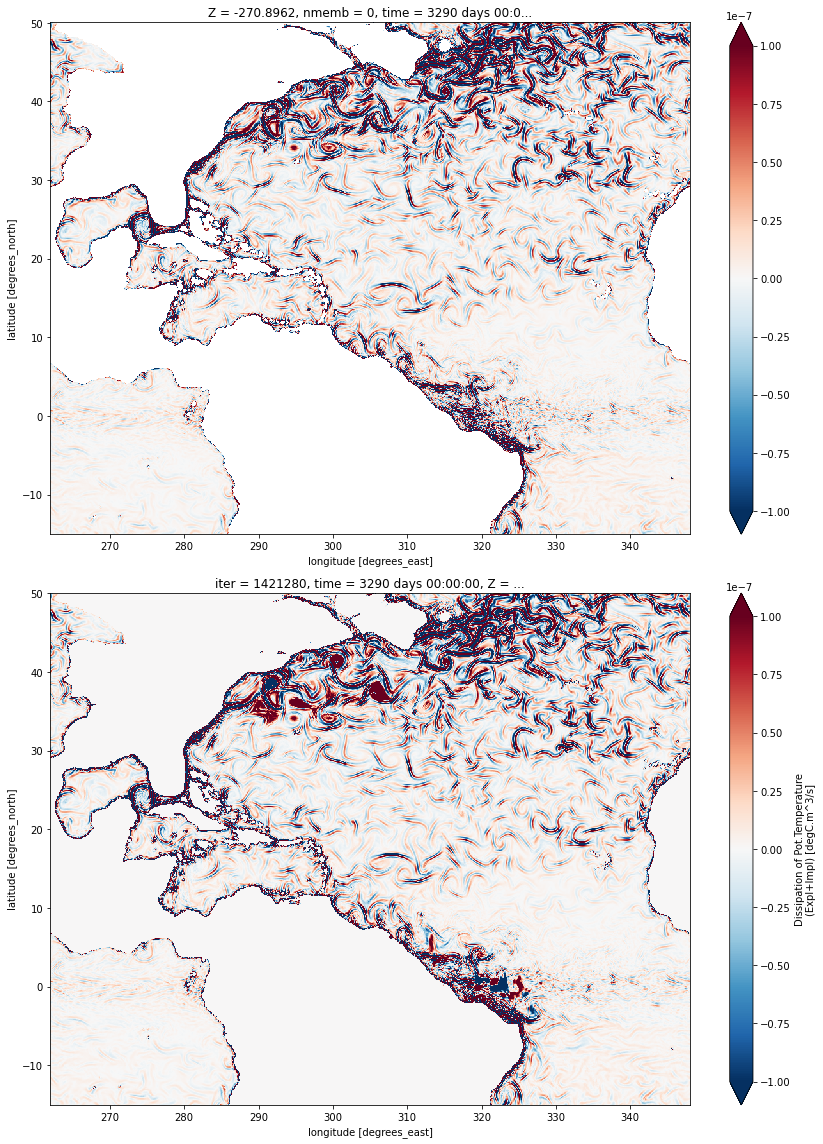

In [15]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,16))
fig.set_tight_layout(True)
GT_diff.isel(nmemb=0,Z=15).sel(YC=slice(-15,50+12**-1)).plot(ax=ax1, vmax=1e-7)
ds.Diss_TH.isel(nmemb=0,Z=15).sel(YC=slice(-15,50+12**-1)).plot(ax=ax2, vmax=1e-7)

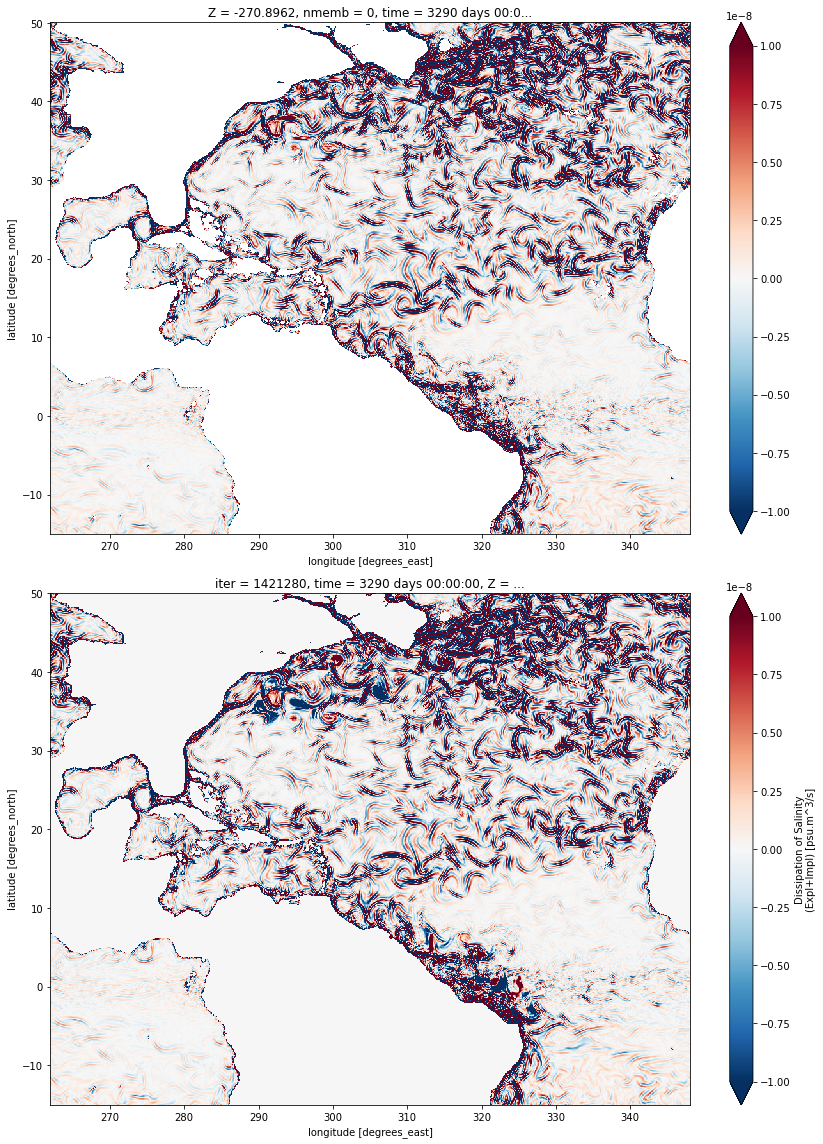

In [16]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,16))
fig.set_tight_layout(True)
GS_diff.isel(nmemb=0,Z=15).sel(YC=slice(-15,50+12**-1)).plot(ax=ax1, vmax=1e-8)
ds.Diss_SLT.isel(nmemb=0,Z=15).sel(YC=slice(-15,50+12**-1)).plot(ax=ax2, vmax=1e-8)

In [5]:
# years = np.arange(2008,2013,dtype=int)
# ntimes = np.arange(7886160,8672400+dnf,dnf).reshape(len(years),nfile)
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1421280,1576800+dnf,dnf).reshape(len(years),nfile)
yystart = 0
dstart = 0
ntimes[yystart,dstart:]

array([1421280, 1423440, 1425600, 1427760, 1429920, 1432080, 1434240,
       1436400, 1438560, 1440720, 1442880, 1445040, 1447200, 1449360,
       1451520, 1453680, 1455840, 1458000, 1460160, 1462320, 1464480,
       1466640, 1468800, 1470960, 1473120, 1475280, 1477440, 1479600,
       1481760, 1483920, 1486080, 1488240, 1490400, 1492560, 1494720,
       1496880, 1499040, 1501200, 1503360, 1505520, 1507680, 1509840,
       1512000, 1514160, 1516320, 1518480, 1520640, 1522800, 1524960,
       1527120, 1529280, 1531440, 1533600, 1535760, 1537920, 1540080,
       1542240, 1544400, 1546560, 1548720, 1550880, 1553040, 1555200,
       1557360, 1559520, 1561680, 1563840, 1566000, 1568160, 1570320,
       1572480, 1574640, 1576800])

In [27]:
yy = yystart

for year in years[yystart:]:
    if year == years[yystart]:
        mtimes = ntimes[yy,dstart:]
    else:
        mtimes = ntimes[yy]
    for itime in mtimes:
        
        for nmemb in range(24):
            if nmemb == 0:
                ds1 = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' % (nmemb,year)), 
                                      grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                      prefix=['diag_ocnTave'], 
                                      delta_t=2e2, iters=itime,
                                      chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                     )
            else:
                ds1 = xr.concat([ds1, open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                              % (nmemb,year)), 
                                                      grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                      prefix=['diag_ocnTave'], 
                                                      delta_t=2e2, iters=itime,
                                                      chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                                     )
                               ], 'nmemb')
        ds1.coords['nmemb'] = ('nmemb',range(24))
        
        if itime == mtimes[0]:
            xA = ds1.hFacW * ds1.dyG * ds1.drF
            yA = ds1.hFacS * ds1.dxG * ds1.drF
            dxC_r = ds1.dxC**-1
            dyC_r = ds1.dyC**-1
            dxG_r = ds1.dxG**-1
            dyG_r = ds1.dyG**-1
            drF_r = ds1.drF**-1
            drC_r = ds1.drC**-1
            hFacC_r = ds1.hFacC**-1
            rA_r = ds1.rA**-1
            pres = rho0*grav*(-ds1.Z) * 1e-4                           # convert to [dbar]
            grid = Grid(ds1, periodic=['X'])
            
        theta1 = ds1.THETA.where(ds1.maskC!=0.)
        salt1 = ds1.SALT.where(ds1.maskC!=0.)
        
        rho1 = xr.apply_ufunc(densjmd95, salt1, theta1, pres,            # pressure in [dbar]!!!!
                              dask='parallelized', output_dtypes=[float,]
                             ).where(ds1.maskC!=0.)
        rho1_s = xr.apply_ufunc(drhods, salt1, theta1, pres,             # pressure in [dbar]!!!!
                                dask='parallelized', output_dtypes=[float,]
                               ).where(ds1.maskC!=0.)
        rho1_th = xr.apply_ufunc(drhodt, salt1, theta1, pres,            # pressure in [dbar]!!!!
                                 dask='parallelized', output_dtypes=[float,]
                                ).where(ds1.maskC!=0.)
        
        dTdx = xA * grid.diff(ds1.THETA,'X') * dxC_r
        dTdy = yA * grid.diff(ds1.THETA,'Y',boundary='fill') * dyC_r
        del2T = rA_r * drF_r * hFacC_r * (grid.diff(dTdx,'X') 
                                          + grid.diff(dTdy,'Y',boundary='fill')
                                         )
######### xA for the harmonic term is already in dTdx
        FxT_diff = -Kh*dTdx + K4*xA*dxC_r*grid.diff(del2T,'X')
######### yA for the harmonic term is already in dTdy
        FyT_diff = -Kh*dTdy + K4*yA*dyC_r*grid.diff(del2T,'Y',boundary='fill')
        FrT_diff = -Kr*ds1.rA * drC_r * -grid.diff(ds1.THETA,'Z',boundary='fill',to='outer')
        
        dSdx = xA * grid.diff(ds1.SALT,'X') * dxC_r
        dSdy = yA * grid.diff(ds1.SALT,'Y',boundary='fill') * dyC_r
        del2S = rA_r * drF_r * hFacC_r * (grid.diff(dSdx,'X') 
                                          + grid.diff(dSdy,'Y',boundary='fill')
                                         )
######### xA for the harmonic term is already in dSdx
        FxS_diff = -Kh*dSdx + K4*xA*dxC_r*grid.diff(del2S,'X')
######### yA for the harmonic term is already in dSdy
        FyS_diff = -Kh*dSdy + K4*yA*dyC_r*grid.diff(del2S,'Y',boundary='fill')
        FrS_diff = -Kr*ds1.rA * drC_r * -grid.diff(ds1.SALT,'Z',boundary='fill',to='outer')
        
        
        GT_diff = -(grid.diff(FxT_diff,'X').where(ds1.maskInC!=0.) 
                    + grid.diff(FyT_diff,'Y',boundary='fill').where(ds1.maskInC!=0.)
                    - grid.diff(FrT_diff,'Z',boundary='fill')
                   ) * hFacC_r * drF_r * rA_r
        GS_diff = -(grid.diff(FxS_diff,'X').where(ds1.maskInC!=0.) 
                    + grid.diff(FyS_diff,'Y',boundary='fill').where(ds1.maskInC!=0.)
                    - grid.diff(FrS_diff,'Z',boundary='fill')
                   ) * hFacC_r * drF_r * rA_r
        
        for nmemb in range(36,60):
            if nmemb == 36:
                ds2 = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' % (nmemb,year)), 
                                      grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                      prefix=['diag_ocnTave','diag_TSbgt2D','diag_dissTS'], 
                                      delta_t=2e2, iters=itime,
                                      chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                     )
            else:
                ds2 = xr.concat([ds2, open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                              % (nmemb,year)), 
                                                      grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                      prefix=['diag_ocnTave','diag_TSbgt2D','diag_dissTS'], 
                                                      delta_t=2e2, iters=itime,
                                                      chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                                     )
                               ], 'nmemb')
        ds2.coords['nmemb'] = ('nmemb',range(24,48))
        
        theta2 = ds2.THETA.where(ds2.maskC!=0.)
        salt2 = ds2.SALT.where(ds2.maskC!=0.)
        swfrac_t = .62 * np.exp(ds2.Zl/.6) + (1-.62) * np.exp(ds2.Zl/20.)
        swfrac1_t = .62 * np.exp(ds2.Zl.shift(Zl=-1)/.6) + (1-.62) * np.exp(ds2.Zl.shift(Zl=-1)/20.)
        Qsw = (ds2.oceQsw / (rho0*Cp) / (ds2.drF*ds2.hFacC) 
               * (swfrac_t - swfrac1_t).data
              ).where(ds2.maskC!=0.)
        Tflx = ((ds2.TFLUX - ds2.oceQsw) 
                / (rho0*Cp*ds2.drF[0]*ds2.hFacC.isel(Z=0))
               ).where(ds2.maskInC!=0.)
        tsurf_corr = 0.                                                  # linFSConverveTr = F.
        Surf_tcorr = (tsurf_corr - ds2.WTHMASS.where(ds2.maskInC!=0.)
                     ) / (ds2.drF[0]*ds2.hFacC.isel(Z=0))
        
#         swfrac_s = .62 * np.exp(ds2.Zl/.6) + (1-.62) * np.exp(ds2.Zl/20.)
#         swfrac1_s = .62 * np.exp(ds2.Zl.shift(Zl=-1)/.6) + (1-.62) * np.exp(ds2.Zl.shift(Zl=-1)/20.)
#         Ffw = (ds2.oceFWflx / (rho0*ds2.drF*ds2.hFacC) 
#                * (swfrac - swfrac1).data
#               ).where(ds2.maskC!=0.)
        Sflx = (ds2.SFLUX / (rho0*ds2.drF[0]*ds2.hFacC.isel(Z=0))
               ).where(ds2.maskInC!=0.)
        ssurf_corr = 0.                                                  # linFSConverveTr = F.
        Surf_scorr = (ssurf_corr - ds2.WSLTMASS.where(ds2.maskInC!=0.)
                     ) / (ds2.drF[0]*ds2.hFacC.isel(Z=0))

        rho2 = xr.apply_ufunc(densjmd95, salt2, theta2, pres,            # pressure in [dbar]!!!!
                              dask='parallelized', output_dtypes=[float,]
                             ).where(ds2.maskC!=0.)
        rho2_s = xr.apply_ufunc(drhods, salt2, theta2, pres,             # pressure in [dbar]!!!!
                                dask='parallelized', output_dtypes=[float,]
                               ).where(ds2.maskC!=0.)
        rho2_th = xr.apply_ufunc(drhodt, salt2, theta2, pres,            # pressure in [dbar]!!!!
                                 dask='parallelized', output_dtypes=[float,]
                                ).where(ds2.maskC!=0.)
        
        dsave = xr.concat([(rho1_th*GT_diff).sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                           (rho2_th*(ds2.Diss_TH + Qsw + Tflx + Surf_tcorr)).sel(YC=slice(ystart-12**-1,yend+2*12**-1))
                          ], 'nmemb').to_dataset(name='VarpiT')
        dsave['VarpiS'] = xr.concat([(rho1_s*GS_diff).sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                                     (rho2_s*(ds2.Diss_SLT + Sflx + Surf_scorr)).sel(YC=slice(ystart-12**-1,yend+2*12**-1))
                                    ], 'nmemb')
        dsave['rho'] = xr.concat([rho1.sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                                  rho2.sel(YC=slice(ystart-12**-1,yend+2*12**-1))
                                 ], 'nmemb')
        dsave = dsave.drop(['rA','PHrefC','hFacC','maskC','maskInC','rhoRef','drF','Depth'])
        dsave = dsave.chunk({'Z':-1,'YC':ychunk,'XC':xchunk})
        if itime == mtimes[0]:
            print(dsave)
        dsave.to_zarr(op.join(savedir,'Varpi_5Dave/run%4d/%010d/' 
                              % (year,itime)), mode='w'
                     )
        ds1.close()
        ds2.close()
        dsave.close()
#         client.restart()
#         cluster.scale(14)
    
        print(itime)
#     print(year)
    yy += 1

<xarray.Dataset>
Dimensions:  (XC: 1000, YC: 783, Z: 46, nmemb: 24, time: 1)
Coordinates:
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 3290 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -15.08 -15.0 -14.92 -14.83 ... 49.83 49.92 50.0 50.08
  * Z        (Z) >f4 -3.047 -9.454 -16.36 ... -5.375e+03 -5.625e+03 -5.875e+03
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
Data variables:
    VarpiT   (nmemb, time, Z, YC, XC) float64 dask.array<chunksize=(1, 1, 46, 250, 250), meta=np.ndarray>
    VarpiS   (nmemb, time, Z, YC, XC) float64 dask.array<chunksize=(1, 1, 46, 250, 250), meta=np.ndarray>
    rho      (nmemb, time, Z, YC, XC) float64 dask.array<chunksize=(1, 1, 46, 250, 250), meta=np.ndarray>
<xarray.Dataset>
Dimensions:  (XC: 1000, YC: 783, Z: 46, nmemb: 24, time: 1)
Coordinates:
    iter     (time) int64 dask.array<chunksize=(1,), m

OSError: [Errno 5] Input/output error: '/tank/chaocean/qjamet/RUNS/ORAR/memb59/run1967/ocn/diag_ocnTave.0001423440.data'

In [8]:
year = 1967
yy = yystart
mstart = 7

for nmemb in range(mstart,24):
    if nmemb == mstart:
        mtimes = ntimes[yy,dstart:]
    else:
        mtimes = ntimes[yy]

    for itime in mtimes:
        ds1 = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' % (nmemb,year)), 
                                  grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                  prefix=['diag_ocnTave'], 
                                  delta_t=2e2, iters=itime
                                 ).chunk({'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk})

        xA = ds1.hFacW * ds1.dyG * ds1.drF
        yA = ds1.hFacS * ds1.dxG * ds1.drF
        dxC_r = ds1.dxC**-1
        dyC_r = ds1.dyC**-1
        dxG_r = ds1.dxG**-1
        dyG_r = ds1.dyG**-1
        drF_r = ds1.drF**-1
        drC_r = ds1.drC**-1
        hFacC_r = ds1.hFacC**-1
        rA_r = ds1.rA**-1
        pres = rho0*grav*(-ds1.Z) * 1e-4                           # convert to [dbar]
        grid = Grid(ds1, periodic=['X'])

        theta1 = ds1.THETA.where(ds1.maskC!=0.)
        salt1 = ds1.SALT.where(ds1.maskC!=0.)

        rho1 = xr.apply_ufunc(densjmd95, salt1, theta1, pres,            # pressure in [dbar]!!!!
                                  dask='parallelized', output_dtypes=[float,]
                                 ).where(ds1.maskC!=0.)
        rho1_s = xr.apply_ufunc(drhods, salt1, theta1, pres,             # pressure in [dbar]!!!!
                                    dask='parallelized', output_dtypes=[float,]
                                   ).where(ds1.maskC!=0.)
        rho1_th = xr.apply_ufunc(drhodt, salt1, theta1, pres,            # pressure in [dbar]!!!!
                                     dask='parallelized', output_dtypes=[float,]
                                    ).where(ds1.maskC!=0.)

        dTdx = xA * grid.diff(ds1.THETA,'X') * dxC_r
        dTdy = yA * grid.diff(ds1.THETA,'Y',boundary='fill') * dyC_r
        del2T = rA_r * drF_r * hFacC_r * (grid.diff(dTdx,'X') 
                                              + grid.diff(dTdy,'Y',boundary='fill')
                                             )
    ######### xA for the harmonic term is already in dTdx
        FxT_diff = -Kh*dTdx + K4*xA*dxC_r*grid.diff(del2T,'X')
    ######### yA for the harmonic term is already in dTdy
        FyT_diff = -Kh*dTdy + K4*yA*dyC_r*grid.diff(del2T,'Y',boundary='fill')
        FrT_diff = -Kr*ds1.rA * drC_r * -grid.diff(ds1.THETA,'Z',boundary='fill',to='outer')

        dSdx = xA * grid.diff(ds1.SALT,'X') * dxC_r
        dSdy = yA * grid.diff(ds1.SALT,'Y',boundary='fill') * dyC_r
        del2S = rA_r * drF_r * hFacC_r * (grid.diff(dSdx,'X') 
                                              + grid.diff(dSdy,'Y',boundary='fill')
                                             )
    ######### xA for the harmonic term is already in dSdx
        FxS_diff = -Kh*dSdx + K4*xA*dxC_r*grid.diff(del2S,'X')
    ######### yA for the harmonic term is already in dSdy
        FyS_diff = -Kh*dSdy + K4*yA*dyC_r*grid.diff(del2S,'Y',boundary='fill')
        FrS_diff = -Kr*ds1.rA * drC_r * -grid.diff(ds1.SALT,'Z',boundary='fill',to='outer')


        GT_diff = -(grid.diff(FxT_diff,'X').where(ds1.maskInC!=0.) 
                        + grid.diff(FyT_diff,'Y',boundary='fill').where(ds1.maskInC!=0.)
                        - grid.diff(FrT_diff,'Z',boundary='fill')
                       ) * hFacC_r * drF_r * rA_r
        GS_diff = -(grid.diff(FxS_diff,'X').where(ds1.maskInC!=0.) 
                        + grid.diff(FyS_diff,'Y',boundary='fill').where(ds1.maskInC!=0.)
                        - grid.diff(FrS_diff,'Z',boundary='fill')
                       ) * hFacC_r * drF_r * rA_r

        dsave = (rho1_th*GT_diff).sel(YC=slice(ystart-12**-1,yend+2*12**-1)).to_dataset(name='VarpiT')
        dsave['VarpiS'] = (rho1_s*GS_diff).sel(YC=slice(ystart-12**-1,yend+2*12**-1))
        dsave['rho'] = rho1.sel(YC=slice(ystart-12**-1,yend+2*12**-1))
        dsave = dsave.drop(['rA','PHrefC','hFacC','maskC','maskInC','rhoRef','drF','Depth'])
        dsave = dsave.chunk({'Z':-1,'YC':ychunk,'XC':xchunk})
        if nmemb == mstart and itime == mtimes[0]:
            print(ds1,dsave)
        dsave.to_zarr(op.join(tdgs,'Varpi_5Dave/run%4d/memb%02d/%010d/' 
                                  % (year,nmemb,itime)), mode='w'
                         )
        ds1.close()
        dsave.close()
        
    print(nmemb)

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 900, YG: 900, Z: 46, Zl: 46, Zp1: 47, Zu: 46, time: 1)
Coordinates: (12/33)
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 3290 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
    ...       ...
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 250, 250), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 250, 250), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(250, 250), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(250, 250), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.

In [6]:
year = 1967
yy = yystart
mstart = 36

for nmemb in range(mstart,60):
    if nmemb == mstart:
        mtimes = ntimes[yy,dstart:]
    else:
        mtimes = ntimes[yy]

    for itime in mtimes:
        ds2 = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' % (nmemb,year)), 
                                  grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                  prefix=['diag_ocnTave','diag_TSbgt2D','diag_dissTS'], 
                                  delta_t=2e2, iters=itime
                                 ).chunk({'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk})

        xA = ds2.hFacW * ds2.dyG * ds2.drF
        yA = ds2.hFacS * ds2.dxG * ds2.drF
        dxC_r = ds2.dxC**-1
        dyC_r = ds2.dyC**-1
        dxG_r = ds2.dxG**-1
        dyG_r = ds2.dyG**-1
        drF_r = ds2.drF**-1
        drC_r = ds2.drC**-1
        hFacC_r = ds2.hFacC**-1
        rA_r = ds2.rA**-1
        pres = rho0*grav*(-ds2.Z) * 1e-4                           # convert to [dbar]
        grid = Grid(ds2, periodic=['X'])

        theta2 = ds2.THETA.where(ds2.maskC!=0.)
        salt2 = ds2.SALT.where(ds2.maskC!=0.)
        swfrac_t = .62 * np.exp(ds2.Zl/.6) + (1-.62) * np.exp(ds2.Zl/20.)
        swfrac1_t = .62 * np.exp(ds2.Zl.shift(Zl=-1)/.6) + (1-.62) * np.exp(ds2.Zl.shift(Zl=-1)/20.)
        Qsw = (ds2.oceQsw / (rho0*Cp) / (ds2.drF*ds2.hFacC) 
                   * (swfrac_t - swfrac1_t).data
                  ).where(ds2.maskC!=0.)
        Tflx = ((ds2.TFLUX - ds2.oceQsw) 
                    / (rho0*Cp*ds2.drF[0]*ds2.hFacC.isel(Z=0))
                   ).where(ds2.maskInC!=0.)
        tsurf_corr = 0.                                                  # linFSConverveTr = F.
        Surf_tcorr = (tsurf_corr - ds2.WTHMASS.where(ds2.maskInC!=0.)
                         ) / (ds2.drF[0]*ds2.hFacC.isel(Z=0))

    #         swfrac_s = .62 * np.exp(ds2.Zl/.6) + (1-.62) * np.exp(ds2.Zl/20.)
    #         swfrac1_s = .62 * np.exp(ds2.Zl.shift(Zl=-1)/.6) + (1-.62) * np.exp(ds2.Zl.shift(Zl=-1)/20.)
    #         Ffw = (ds2.oceFWflx / (rho0*ds2.drF*ds2.hFacC) 
    #                * (swfrac - swfrac1).data
    #               ).where(ds2.maskC!=0.)
        Sflx = (ds2.SFLUX / (rho0*ds2.drF[0]*ds2.hFacC.isel(Z=0))
                   ).where(ds2.maskInC!=0.)
        ssurf_corr = 0.                                                  # linFSConverveTr = F.
        Surf_scorr = (ssurf_corr - ds2.WSLTMASS.where(ds2.maskInC!=0.)
                         ) / (ds2.drF[0]*ds2.hFacC.isel(Z=0))

        rho2 = xr.apply_ufunc(densjmd95, salt2, theta2, pres,            # pressure in [dbar]!!!!
                                  dask='parallelized', output_dtypes=[float,]
                                 ).where(ds2.maskC!=0.)
        rho2_s = xr.apply_ufunc(drhods, salt2, theta2, pres,             # pressure in [dbar]!!!!
                                    dask='parallelized', output_dtypes=[float,]
                                   ).where(ds2.maskC!=0.)
        rho2_th = xr.apply_ufunc(drhodt, salt2, theta2, pres,            # pressure in [dbar]!!!!
                                     dask='parallelized', output_dtypes=[float,]
                                    ).where(ds2.maskC!=0.)

        dsave = (rho2_th*(ds2.Diss_TH + Qsw + Tflx + Surf_tcorr)
                    ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)).to_dataset(name='VarpiT')
        dsave['VarpiS'] = (rho2_s*(ds2.Diss_SLT + Sflx + Surf_scorr)).sel(YC=slice(ystart-12**-1,yend+2*12**-1))
        dsave['rho'] = rho2.sel(YC=slice(ystart-12**-1,yend+2*12**-1))
        dsave = dsave.drop(['rA','PHrefC','hFacC','maskC','maskInC','rhoRef','drF','Depth'])
        dsave = dsave.chunk({'Z':-1,'YC':ychunk,'XC':xchunk})
        if nmemb == mstart and itime == mtimes[0]:
            print(ds2,dsave)
        dsave.to_zarr(op.join(tdgs,'Varpi_5Dave/run%4d/memb%02d/%010d/' 
                                  % (year,nmemb,itime)), mode='w'
                         )
        ds2.close()
        dsave.close()
    print(nmemb)

<xarray.Dataset>
Dimensions:   (XC: 1000, XG: 1000, YC: 900, YG: 900, Z: 46, Zl: 46, Zp1: 47, Zu: 46, time: 1)
Coordinates: (12/33)
    iter      (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time      (time) timedelta64[ns] 3290 days
  * XC        (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC        (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG        (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG        (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
    ...        ...
    maskW     (Z, YC, XG) bool dask.array<chunksize=(46, 250, 250), meta=np.ndarray>
    maskS     (Z, YG, XC) bool dask.array<chunksize=(46, 250, 250), meta=np.ndarray>
    maskInC   (YC, XC) bool dask.array<chunksize=(250, 250), meta=np.ndarray>
    rhoRef    (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskInW   (YC, XG) bool dask.array<chunksize=(250, 250), meta=np.ndarray>
    maskInS   (YG, 

In [37]:
dsave.to_zarr(op.join(tdgs,'Varpi_5Dave/run%4d/memb%02d/' 
                              % (year,nmemb)), mode='w'
                     )

KeyboardInterrupt: 

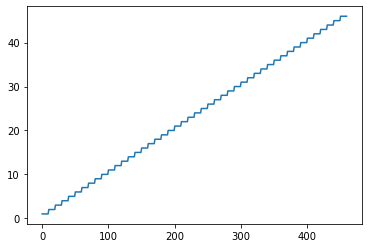

In [40]:
drf_finer, mapindex, mapfact, cellindex = finegrid.finegrid(np.squeeze(dsocn.drF.sel(Z=slice(None,None))),
                                                            np.squeeze(dsocn.drC.sel(Zp1=slice(None,None))),
                                                            10)
# drc_finer, _, _, _ = finegrid.finegrid(np.squeeze(dsocn.drC.isel(Zp1=slice(None,-1))),
#                                       np.squeeze(dsocn.drC.sel(Zp1=slice(None,None))),
#                                       10)

plt.plot(cellindex)

In [41]:
Dsig = 9.7
nlayers = 43

tmp = np.tanh(np.linspace(-2.,2.75,nlayers))
tmp += np.abs(tmp.min())
tmp *= tmp.max()**-1 * Dsig
# print(tmp)
siglayers = 27.5 + tmp
func = interp1d(range(1,nlayers+1), siglayers, fill_value='extrapolate')
sigp1layers = func(np.arange(.5,nlayers+1.5,1))

In [76]:
GTdz = xr.DataArray(np.ones((len(dsocn.nmemb),
                             len(dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                             len(dsocn.XC),len(siglayers))),
                    dims=['nmemb','YC','XC','sig'],
                    coords={'nmemb':range(2),
                            'YC':dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                            'XC':dsocn.XC.data,'sig':siglayers}
                   ) * np.nan
Gsdz = GTdz.copy()
Tdz = GTdz.copy()
sdz = GTdz.copy()

for tt in range(2):
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          DibaT[tt].where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                        yend+2*12**-1)
                                                              ).chunk({'Z':-1,'YC':-1,
                                                                       'XC':xchunk}),
                          (rho2[tt]-1e3).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                             yend+2*12**-1)
                                                                   ).chunk({'XC':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()

    tmp2 = xr.apply_ufunc(layers_numpy, 
                          DibaS[tt].where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                        yend+2*12**-1)
                                                              ).chunk({'Z':-1,'YC':-1,
                                                                       'XC':xchunk}),      
                          (rho2[tt]-1e3).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                             yend+2*12**-1)
                                                                   ).chunk({'XC':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp3 = xr.apply_ufunc(layers_numpy, 
                          dsocn.THETA[tt].where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                              yend+2*12**-1)
                                                                    ),
                          (rho2[tt]-1e3).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                             yend+2*12**-1)
                                                                   ).chunk({'XC':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()

    tmp4 = xr.apply_ufunc(layers_numpy, 
                          dsocn.SALT[tt].where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                             yend+2*12**-1)
                                                                   ),      
                          (rho2[tt]-1e3).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                             yend+2*12**-1)
                                                                   ).chunk({'XC':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()

        
#     if tt == 0:
#         GTdz = tmp1
#         Gsdz = tmp2
# #         dzetaF = tmpdzetaF
#     else:
#         GTdz = xr.concat([GTdz, tmp1], dim='nmemb')
#         Gsdz = xr.concat([Gsdz, tmp2], dim='nmemb')
# #         dzetaF = xr.concat([dzetaF, tmpdzetaF], dim='time')
    GTdz[tt] = tmp1
    Gsdz[tt] = tmp2
    Tdz[tt] = tmp3
    sdz[tt] = tmp4
    
    del tmp1, tmp2, tmp3, tmp4

    
GTdz = GTdz.chunk({'nmemb':1,'sig':1})
Gsdz = Gsdz.chunk({'nmemb':1,'sig':1})
Tdz = Tdz.chunk({'nmemb':1,'sig':1})
sdz = sdz.chunk({'nmemb':1,'sig':1})
GTdz

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 43)>
dask.array<xarray-<this-array>, shape=(2, 723, 1000, 43), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2

In [53]:
dzetaF = GTdz.load().copy() * np.nan
# dzetaF.coords['time'] = ('time',ds.time.data)

for j in range(2):
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          xr.ones_like(rho2[j]).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                                    yend+2*12**-1)
                                                                          ).chunk({'XC':xchunk}),
                          (rho2[j]-1e3).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                            yend+2*12**-1)
                                                                  ).chunk({'XC':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
            #                            output_core_dims=(['sig2lev']),
            #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
            
    dzetaF[j] = tmp1.data
    
    del tmp1
    
dzetaF = dzetaF.chunk({'nmemb':1,'sig':1})
dzetaF

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 43)>
dask.array<xarray-<this-array>, shape=(2, 723, 1000, 43), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2

In [54]:
dssig = dzetaF.to_dataset(name='dzetaF')
dssig.coords['YG'] = ('YG',dsocn.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data)
dssig.coords['XG'] = ('XG',dsocn.XG.data)
# dssig.coords['rAs'] = (('YG','XC'),vdz.rAs.data)
# dssig.coords['rAw'] = (('YC','XG'),udz.rAw.data)
# dssig.coords['rAs'] = (('YG','XC'),vdz.rAs.data)
# dssig.coords['rAw'] = (('YC','XG'),udz.rAw.data)
dssig.coords['sigp1'] = ('sigp1',sigp1layers)
# dt = np.diff(ds.time)[0]
# dssig.coords['timep1'] = ('timep1',np.append(np.append(ds.time[0].data-.5*dt,
#                                                        .5*(ds.time[1:].data+ds.time[:-1].data)),
#                                              ds.time[-1].data+.5*dt))
dssig

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 723, YG: 723, nmemb: 2, sig: 43, sigp1: 44)
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2
  * YG       (YG) >f4 -10.041633 -9.9583 -9.874967 ... 50.041702 50.125034
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * sigp1    (sigp1) float64 27.48 27.52 27.57 27.63 ... 37.17 37.18 37.19 37.21
Data variables:
    dzetaF   (nmemb, YC, XC, sig) float64 dask.array<chunksize=(1, 723, 1000, 1), meta=np.ndarray>

In [55]:
grids = xgrid(dssig, periodic=['X'], 
              coords={'Z':{'center':'sig','outer':'sigp1'},
                      'Y':{'center':'YC','left':'YG'},
                      'X':{'center':'XC','left':'XG'}}
             )
grids

<xgcm.Grid>
Z Axis (not periodic):
  * center   sig --> outer
  * outer    sigp1 --> center
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center

In [96]:
sigma = (dzetaF * grids.diff(dssig.sigp1,'Z',boundary='fill')**-1)
zeta = -grids.interp(grids.cumsum(dzetaF,'Z',boundary='fill'),'Z',boundary='fill')
sigma

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 43)>
dask.array<mul, shape=(2, 723, 1000, 43), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2

In [63]:
angle = np.sqrt(1 + (dzetaF/grid.interp(dsocn.dxG,'Y',boundary='fill'))**2 
                + (dzetaF/grid.interp(dsocn.dyG,'X'))**2
               )**-1
angley = np.sqrt(1 + (grids.interp(dzetaF,'Y',boundary='fill')/dsocn.dxG)**2 
                + (grids.interp(dzetaF,'Y',boundary='fill')
                   / grid.interp(grid.interp(dsocn.dyG,'X'),'Y',boundary='fill')
                  )**2
                )**-1
anglex = np.sqrt(1 + (grids.interp(dzetaF,'X')
                      / grid.interp(grid.interp(dsocn.dxG,'Y',boundary='fill'),'X')
                     )**2 
                + (grids.interp(dzetaF,'X')/dsocn.dyG)**2
                )**-1
anglez = np.sqrt(1 + (grids.interp(dzetaF,'Z',boundary='fill')
                      / grid.interp(dsocn.dxG,'Y',boundary='fill')
                     )**2 
                 + (grids.interp(dzetaF,'Z',boundary='fill')
                    / grid.interp(dsocn.dyG,'X')
                   )**2
                )**-1
print(angle,angley,anglex,anglez)

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 43)>
dask.array<pow, shape=(2, 723, 1000, 43), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 -10.08 -10.0 -9.917 -9.833 ... 49.83 49.92 50.0 50.08
  * nmemb    (nmemb) int64 0 1
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2 <xarray.DataArray (nmemb: 2, YG: 723, XC: 1000, sig: 43)>
dask.array<pow, shape=(2, 723, 1000, 43), dtype=float64, chunksize=(1, 722, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * YG       (YG) float64 -10.04 -9.958 -9.875 -9.792 ... 49.96 50.04 50.13
  * nmemb    (nmemb) int64 0 1
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2
    time     float64 1.577e+08
    rAs      (YG, XC) >f4 87285460.0 87285460.0 ... 56830530.0 56830530.0
    dxG      

In [71]:
rAb = angle**-1 * dsocn.rA
rAbw = anglex**-1 * dsocn.rAw
rAbs = angley**-1 * dsocn.rAs
rAbz = anglez**-1 * dsocn.rA
rAb

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 43)>
dask.array<mul, shape=(2, 723, 1000, 43), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 -10.08 -10.0 -9.917 -9.833 ... 49.83 49.92 50.0 50.08
  * nmemb    (nmemb) int64 0 1
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2
    time     float64 1.577e+08
    rA       (YC, XC) >f4 87274190.0 87274190.0 ... 56879988.0 56879988.0
    iter     int64 788400
    maskInC  (YC, XC) bool True True True True True ... True True True True True
    Depth    (YC, XC) >f4 3055.816 3048.596 3159.5232 ... 2158.6245 2124.6829

In [77]:
dbdT = grids.diff(Tdz*dzetaF**-1*rAb,
                  'Z',boundary='fill'
                 )**-1 * (grids.diff(dssig.sig,'Z',boundary='fill') 
                          * rAbz
                         )
dbds = grids.diff(sdz*dzetaF**-1*rAb,
                  'Z',boundary='fill'
                 )**-1 * (grids.diff(dssig.sig,'Z',boundary='fill') 
                          * rAbz
                         )

varpi = (dbdT*grids.interp(GTdz*dzetaF**-1,'Z',boundary='fill') 
         + dbds*grids.interp(Gsdz*dzetaF**-1,'Z',boundary='fill')
        )
varpi

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sigp1: 44)>
dask.array<add, shape=(2, 723, 1000, 44), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sigp1    (sigp1) float64 27.48 27.52 27.57 27.63 ... 37.17 37.18 37.19 37.21
    time     float64 1.577e+08
    rA       (YC, XC) >f4 87274190.0 87274190.0 ... 56879988.0 56879988.0
    iter     int64 788400
    maskInC  (YC, XC) bool True True True True True ... True True True True True
    Depth    (YC, XC) >f4 3055.816 3048.596 3159.5232 ... 2158.6245 2124.6829

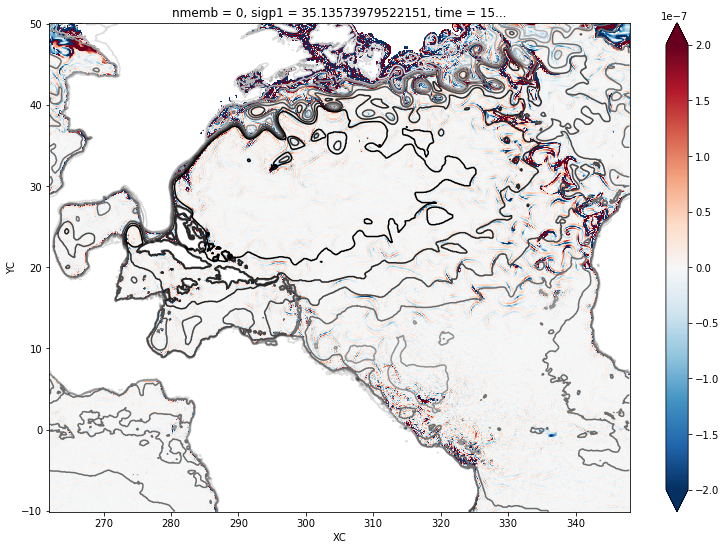

In [94]:
fig, ax = plt.subplots(figsize=(13,9))
cs = zeta[0,:,:,24].plot.contour(ax=ax, levels=np.linspace(0,500,8), cmap='binary')
for c in cs.collections:
    c.set_rasterized(True)
varpi[0,:,:,24].plot(ax=ax, vmax=2e-7, rasterized=True)

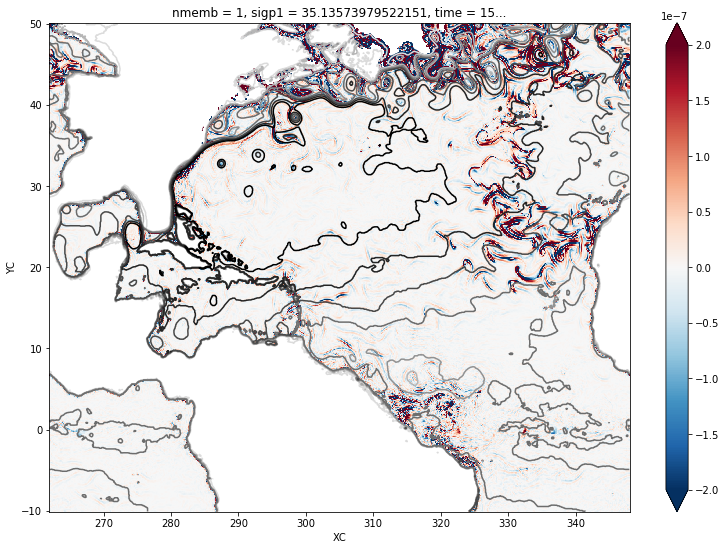

In [95]:
fig, ax = plt.subplots(figsize=(13,9))
cs = zeta[1,:,:,24].plot.contour(ax=ax, levels=np.linspace(0,500,8), cmap='binary')
for c in cs.collections:
    c.set_rasterized(True)
varpi[1,:,:,24].plot(ax=ax, vmax=2e-7, rasterized=True)